In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import copy
import glob
import typing

from IPython.display import display, Markdown

from collections import defaultdict
import numpy as np
import pandas as pd
from pandas.core.groupby import SeriesGroupBy  # type: ignore
import scipy
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.axes
import matplotlib.patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

from simple_relational_reasoning.embeddings.visualizations import DEFAULT_COLORMAP, DEFAULT_BAR_KWARGS, DEFAULT_TEXT_KWARGS, DEFAULT_YLIM, plot_prettify, filter_and_group, save_plot  # type: ignore


In [42]:
USE_LARGER_RESUTLS = True

IGNORE_SMALLER_LIST = ('baseline.csv', 'dino.csv', 'flipping.csv')
IGNORE_LARGER_LIST = ('baseline_larger_dataset.csv', 'dino_larger_dataset.csv', 'flipping_larger_dataset.csv')
CORRECT_KEY = 'containment_high_containment_cos'
INCORRECT_KEYS = ['containment_behind_cos', 'containment_support_cos']
ORDERED_COLUMNS = ['model', 'training', 'flip', 'dino', 'configuration_index', 'example_index', 'bowl_color', 'target_object', 
        'containment_high_containment_cos', 'containment_behind_cos', 'containment_support_cos',
        'high_containment_behind_cos', 'high_containment_support_cos', 'behind_support_cos', 
        'correct', 'cos_ratio', 'cos_diff', 'behind_similar', 'support_similar']
TARGET_OBJECTS = ['BeachBall', 'Knight', 'Lego', 'Pineapple', 'Robot', 'RubberDuck', 'Teddy', 'Truck']


def load_and_join_dataframes(folder: str, ext: str = '.csv', ignore_list: typing.Sequence[str] = tuple()) -> pd.DataFrame:
    files = glob.glob(os.path.join(folder, '*' + ext))
    df = pd.concat([pd.read_csv(f) for f in files if os.path.basename(f) not in ignore_list])
    df.reset_index(drop=True, inplace=True)
    return df


def parse_model_name(df: pd.DataFrame) -> pd.DataFrame:
    new_series_values = defaultdict(list)

    for name in df.model:
        split_index = name.index('-')
        base_model, training_type = name[:split_index], name[split_index + 1:]

        flip = None
        dino = None

        if 'DINO' in training_type:
            training_type, dino = training_type.split('-')
            if dino == 'S':
                dino = 'saycam(S)'

        if '-' in training_type:
            training_type, flip = training_type.split('-')
            training_type += '-flip'

        if training_type == 'imagenet':
            training_type = 'ImageNet'

        new_series_values['model'].append(base_model)
        new_series_values['training'].append(training_type)
        new_series_values['flip'].append(flip)
        new_series_values['dino'].append(dino)

    return df.assign(**new_series_values)


def _key_to_similarity_key(key: str) -> str:
    return f'{key.split("_")[1]}_similar'


def evaluate_accuracy(df: pd.DataFrame, correct_key: str = CORRECT_KEY, 
    incorrect_keys: typing.Sequence[str] = INCORRECT_KEYS) -> pd.DataFrame:
    correct = []
    cos_ratio = []
    cos_diff = []
    incorrects = {_key_to_similarity_key(key): [] for key in incorrect_keys}

    for _, row in df.iterrows():    
        correct_val = row[correct_key]
        max_incorrect_val = max([row[k] for k in incorrect_keys])  # type: ignore

        correct.append(correct_val >= max_incorrect_val)
        cos_ratio.append(correct_val / max_incorrect_val)
        cos_diff.append(correct_val - max_incorrect_val)

        for key in incorrect_keys:
            incorrects[_key_to_similarity_key(key)].append(row[key] == max_incorrect_val and row[key] > correct_val)

    return df.assign(correct=correct, cos_ratio=cos_ratio, cos_diff=cos_diff, **incorrects)


def full_load_pipeline(folder: str, ignore_list: typing.Sequence[str] = tuple()):
    df = load_and_join_dataframes(folder, ignore_list=ignore_list)
    df.drop(columns=[df.columns[0]], inplace=True)  # type: ignore
    df = parse_model_name(df)
    # df = add_target_object_field(df)
    df = evaluate_accuracy(df)
    df = df[ORDERED_COLUMNS]
    return df


larger_df = full_load_pipeline('../containment_support_outputs', ignore_list=IGNORE_SMALLER_LIST)
smaller_df = full_load_pipeline('../containment_support_outputs', ignore_list=IGNORE_LARGER_LIST)
print(larger_df.shape, smaller_df.shape)

if USE_LARGER_RESUTLS:
    combined_df = larger_df
else:
    combined_df = smaller_df


print(combined_df.shape)
combined_df.head()

(98304, 19) (12288, 19)
(98304, 19)


,model,training,flip,dino,configuration_index,example_index,bowl_color,target_object,containment_high_containment_cos,containment_behind_cos,containment_support_cos,high_containment_behind_cos,high_containment_support_cos,behind_support_cos,correct,cos_ratio,cos_diff,behind_similar,support_similar
0,mobilenet,saycam(S),None,None,0,0,brown,BeachBall,0.688618,0.694082,0.686518,0.919431,0.909603,0.945790,False,0.992128,-0.005464,True,False
1,mobilenet,saycam(S),None,None,0,1,brown,Knight,0.687624,0.701440,0.686347,0.945321,0.894987,0.950158,False,0.980304,-0.013815,True,False
2,mobilenet,saycam(S),None,None,0,2,brown,Lego,0.656459,0.666799,0.688689,0.943674,0.903153,0.944568,False,0.953202,-0.032230,False,True
3,mobilenet,saycam(S),None,None,0,3,brown,Pineapple,0.726964,0.700646,0.693675,0.922813,0.889657,0.956212,True,1.037562,0.026318,False,False
4,mobilenet,saycam(S),None,None,0,4,brown,Robot,0.740586,0.686011,0.690598,0.913016,0.865253,0.930358,True,1.072384,0.049988,False,False


In [51]:
DEFAULT_ORDERS = {
    'model_name': ['mobilenet', 'resnext'],
    'training': ['saycam(S)', 'ImageNet', 'random'],
    'above_below_type': ['one_reference', 'adjacent_references', 'gapped_references'],
    'flip': ['s', 'h', 'v', 'hv'],
    'triplet_generator': ['diagonal', 'equidistant'],
    'same_horizontal_half': [True, False],
    'condition': ['different_shapes', 'split_text', 'random_color'],
}

# nested dict, where the first key is the style (name, hatch, etc,)
# the second key is the field name (model name, relation, etc)
# the third key is the field value (resnext, mobilenet, etc.)
# and the value is the value for that style keyword
DEFAULT_PLOT_STYLES = dict(
    color=dict(
        # if we color by model
        model={
            'mobilenet': DEFAULT_COLORMAP(0),
            'resnext': DEFAULT_COLORMAP(1),
        },
        # if we color by dino
        dino={
            'ImageNet': DEFAULT_COLORMAP(2), 
            'saycam(S)': DEFAULT_COLORMAP(3),
        },
        # if we color by flip
        flip={
            's': DEFAULT_COLORMAP(4),
            'h': DEFAULT_COLORMAP(5),
            'v': DEFAULT_COLORMAP(6),
            'hv': DEFAULT_COLORMAP(7),
        }
    ),
    hatch=dict(
        n_target_types={
            1: '',
            2: '/',
        },
        n_habituation_stimuli={
            1: '',
            4: '+',
        }
    )
)

DEFAULT_SUBPLOT_ADJUST_PARAMS = dict(top=0.8)

DEFAULT_LINE_KWARGS = dict(marker='.', linestyle='-')

DEFAULT_YALBELS = defaultdict(lambda: 'Accuracy', 
    cos_ratio='Cosine similarity ratio',
    cos_diff='Cosine similarity difference',
)


def plot_single_bar(
    ax: matplotlib.axes.Axes,
    x: float,
    key: typing.Sequence[str],
    mean: pd.core.groupby.SeriesGroupBy,  # type: ignore
    std: pd.core.groupby.SeriesGroupBy,   # type: ignore
    plot_std: bool,
    bar_width: float, 
    bar_kwargs: typing.Dict[str, typing.Any],
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]],
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
):

    key = tuple(key)
    m = mean.loc[key]

    if remap_range is not None:
        m = m * (remap_range[1] - remap_range[0]) + remap_range[0]

    if plot_std:
        s = std.loc[key]
    else:
        s = None

    ax.bar(x, m, yerr=s, width=bar_width, **bar_kwargs, **global_bar_kwargs) 
    # TODO: above bar texts would go here, if they exist
    return x + bar_width 


def plot_single_panel(
    ax: matplotlib.axes.Axes,
    mean: SeriesGroupBy,
    std: SeriesGroupBy,
    plot_std: bool,
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    group_bars_by: str, 
    color_bars_by: str, 
    hatch_bars_by: typing.Optional[str] = None,
    bar_width: float = 0.2, 
    bar_group_spacing: float = 0.5, 
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]] = DEFAULT_BAR_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy', 
):
    x = 0

    for group_by_value in orders_by_field[group_bars_by]:
        for color_by_value in orders_by_field[color_bars_by]:
            bar_kwargs = dict(facecolor=plot_style_by_field['color'][color_bars_by][color_by_value])

            group_and_color_key = [group_by_value, color_by_value]

            if hatch_bars_by is not None:
                for hatch_by_value in orders_by_field[hatch_bars_by]:
                    bar_kwargs['hatch'] = plot_style_by_field['hatch'][hatch_bars_by][hatch_by_value]

                    hatch_key = group_and_color_key[:]
                    hatch_key.append(hatch_by_value)

                    x = plot_single_bar(ax, x, hatch_key, mean, std, 
                        plot_std, bar_width, 
                        bar_kwargs, global_bar_kwargs,
                        remap_range=remap_range)
            
            else:
                x = plot_single_bar(ax, x, group_and_color_key, mean, std, 
                    plot_std, bar_width, 
                    bar_kwargs, global_bar_kwargs,
                    remap_range=remap_range)

        x += bar_group_spacing

    group_values = orders_by_field[group_bars_by]

    group_length = len(orders_by_field[color_bars_by]) * (len(orders_by_field[hatch_bars_by]) if hatch_bars_by is not None else 1)
    x_tick_locations = np.arange(len(group_values)) * (bar_group_spacing + bar_width * group_length) +\
                        bar_width * (group_length / 2 - 0.5)
    xtick_text_kwargs = text_kwargs.copy()
    if len(group_values) > 4:
        xtick_text_kwargs['fontsize'] -= 4
    ax.set_xticks(x_tick_locations)
    ax.set_xticklabels([plot_prettify(val, field_name=group_bars_by) for val in group_values], fontdict=xtick_text_kwargs)
    ax.tick_params(axis='both', which='major', labelsize=text_kwargs['fontsize'] - 4)

    if add_chance_hline:
        xlim = ax.get_xlim()
        if remap_range is not None:
            y_chance = (remap_range[1] - remap_range[0]) * y_chance + remap_range[0]
        ax.hlines(y_chance, *xlim, linestyle='--', alpha=0.5, color='black')
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        if remap_range is not None:
            ylim = (ylim[0] * (remap_range[1] - remap_range[0]) + remap_range[0], ylim[1] * (remap_range[1] - remap_range[0]) + remap_range[0])
        ax.set_ylim(*ylim)

    ax.set_xlabel(plot_prettify(group_bars_by), **text_kwargs)
    _add_ylabel_to_ax(ax, ylabel, text_kwargs)


def line_plot_single_panel(
    ax: matplotlib.axes.Axes,
    mean: SeriesGroupBy,
    std: SeriesGroupBy,
    plot_std: bool,
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    group_bars_by: str, 
    color_bars_by: str, 
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_line_kwargs: typing.Dict[str, typing.Any] = DEFAULT_LINE_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy', 
):

    group_values = orders_by_field[group_bars_by]    
    x_locs = np.arange(len(group_values))
    for color_by_value in orders_by_field[color_bars_by]:
        means = [mean.loc[tuple([group_by_value, color_by_value])] for group_by_value in group_values]
        stds = [std.loc[tuple([group_by_value, color_by_value])] for group_by_value in group_values]

        if remap_range is not None:
            means = [m * (remap_range[1] - remap_range[0]) + remap_range[0] for m in means]

        if plot_std:
            ax.errorbar(x_locs, means, stds, color=plot_style_by_field['color'][color_bars_by][color_by_value],
                **global_line_kwargs)
        else:
            ax.plot(x_locs, means, color=plot_style_by_field['color'][color_bars_by][color_by_value],
                **global_line_kwargs)
    
    xtick_text_kwargs = text_kwargs.copy()
    if len(group_values) > 4:
        xtick_text_kwargs['fontsize'] -= 4
    ax.set_xticks(x_locs)
    ax.set_xticklabels([plot_prettify(val, field_name=group_bars_by) for val in group_values], fontdict=xtick_text_kwargs)
    ax.tick_params(axis='both', which='major', labelsize=text_kwargs['fontsize'] - 4)

    if add_chance_hline:
        xlim = ax.get_xlim()
        if remap_range is not None:
            y_chance = (remap_range[1] - remap_range[0]) * y_chance + remap_range[0]
        ax.hlines(y_chance, *xlim, linestyle='--', alpha=0.5, color='black')
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        if remap_range is not None:
            ylim = (ylim[0] * (remap_range[1] - remap_range[0]) + remap_range[0], ylim[1] * (remap_range[1] - remap_range[0]) + remap_range[0])
        ax.set_ylim(*ylim)

    ax.set_xlabel(plot_prettify(group_bars_by), **text_kwargs)
    _add_ylabel_to_ax(ax, ylabel, text_kwargs)


def _add_ylabel_to_ax(ax: matplotlib.axes.Axes, ylabel: typing.Union[str, typing.Sequence[typing.Dict[str, typing.Any]]], 
    text_kwargs: typing.Dict[str, typing.Any]):

    if isinstance(ylabel, str):
        ax.set_ylabel(ylabel, **text_kwargs)

    elif isinstance(ylabel, (list, tuple)):
        multiple_label_kwargs = copy.copy(text_kwargs)
        multiple_label_kwargs['fontsize'] -= 4

        for ylabel_part in ylabel:
            ax.text(**ylabel_part, transform=ax.transAxes, **multiple_label_kwargs)

    else:
        print(f'Unrecognized ylabel: {ylabel}')


def add_legend_to_ax(ax: matplotlib.axes.Axes, 
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    color_bars_by: str,
    hatch_bars_by: typing.Optional[str] = None,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    legend_loc: typing.Optional[str] = 'best', 
    legend_ncol: typing.Optional[int] = None,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None):

    patches = []

    if legend_ncol is None:
        legend_ncol = 1

    if legend_kwargs is None:
        legend_kwargs = {}

    for color_by_value in orders_by_field[color_bars_by]:
        bar_kwargs = dict(facecolor=plot_style_by_field['color'][color_bars_by][color_by_value])
        patch_kwargs = dict(facecolor='none', edgecolor='black')
        patch_kwargs.update(bar_kwargs)
        patches.append(matplotlib.patches.Patch(**patch_kwargs, label=plot_prettify(color_by_value, color_bars_by)))
    
    if hatch_bars_by is not None:
        for hatch_by_value in orders_by_field[hatch_bars_by]:
            bar_kwargs=dict(hatch=plot_style_by_field['hatch'][hatch_bars_by][hatch_by_value])
            patch_kwargs = dict(facecolor='none', edgecolor='black')
            patch_kwargs.update(bar_kwargs)
            patches.append(matplotlib.patches.Patch(**patch_kwargs, label=plot_prettify(hatch_by_value, hatch_bars_by)))

    if len(patches) > 0: 
        ax.legend(handles=patches, loc=legend_loc, ncol=legend_ncol, 
            fontsize=text_kwargs['fontsize'] - 4, **legend_kwargs)
    

def multiple_bar_plots(df: pd.DataFrame, *,
    # what and how to plot arguments
    filter_dict: typing.Dict[str, typing.Union[str, None, typing.Sequence[str]]],
    group_bars_by: str, 
    color_bars_by: str, 
    panel_by: typing.Union[None, str, typing.Sequence[str]] = None, 
    hatch_bars_by: typing.Optional[str] = None,
    plot_field: str = 'acc_mean',
    compute_std: bool = False,
    plot_std: bool = True,
    sem: bool = True,
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    orders_by_field: typing.Dict[str, typing.List[str]] = DEFAULT_ORDERS,
    # plot style arguments
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]] = DEFAULT_PLOT_STYLES, # type: ignore
    ax: typing.Union[matplotlib.axes.Axes, typing.Sequence[matplotlib.axes.Axes], None] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None,
    layout: typing.Optional[typing.Tuple[int, int]] = None,
    bar_width: float = 0.2, 
    bar_group_spacing: float = 0.5, 
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_bar_kwargs: typing.Dict[str, typing.Any] = DEFAULT_BAR_KWARGS,
    global_line_kwargs: typing.Dict[str, typing.Any] = DEFAULT_LINE_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    title_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: typing.Optional[str] = None,
    ylabel_per_ax: bool = False,
    legend_ax_index: typing.Optional[int] = None, 
    legend_loc: typing.Optional[str] ='best', 
    legend_ncol: typing.Optional[int] = None,
    panel_titles: typing.Union[str, typing.Sequence[str], None] = None,
    sup_title: typing.Optional[str] = None,
    subplot_adjust_params: typing.Dict[str, typing.Any] = DEFAULT_SUBPLOT_ADJUST_PARAMS,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    line_plot: bool = False,
    # plot saving arguments
    save_path: typing.Optional[str] = None, 
    save_should_print: bool = False, 
    ):

    if global_bar_kwargs is None:
        global_bar_kwargs = dict()

    if global_line_kwargs is None:
        global_line_kwargs = dict()

    if title_kwargs is None:
        title_kwargs = {}
    if 'fontsize' not in title_kwargs:
        title_kwargs['fontsize'] = text_kwargs['fontsize'] + 8

    group_by_fields = [group_bars_by, color_bars_by]

    # if panel_by is a list, it's a series of metrics to panel_by
    if panel_by is not None and isinstance(panel_by, str):
        group_by_fields.insert(0, panel_by)
    if hatch_bars_by is not None:
        group_by_fields.append(hatch_bars_by)

    if line_plot and hatch_bars_by is not None:
        raise ValueError(f'Cannot plot line plot with hatch bars by, received: {hatch_bars_by}')

    if ylabel is None:
        ylabel = DEFAULT_YALBELS[plot_field]

    if ylabel_per_ax:
        if panel_by is None:
            raise ValueError(f'Must provide panel_by (received {panel_by}) if ylabel_per_ax is True')

        if len(ylabel) != np.product(layout):
            raise ValueError(f'Must provide ylabel with length equal to product of layout (received {layout}) if ylabel_per_ax is True')

    grouped_df = filter_and_group(df, filter_dict, group_by_fields)

    if panel_by is not None and not isinstance(panel_by, str):
        panel_by_values = []
        for metric in panel_by:
            mean = grouped_df[metric].mean()
            std = grouped_df[plot_field].std()
            if sem:
                std /= np.sqrt(grouped_df[plot_field].count())  # type: ignore

            panel_by_values.append((mean, std))

        mean = panel_by_values[0][0]
    
    else:
        mean = grouped_df[plot_field].mean()

        if compute_std:
            std = grouped_df[plot_field].std()
            if sem:
                std /= np.sqrt(grouped_df[plot_field].count())  # type: ignore
        
        else:
            if sem:
                std = grouped_df.acc_sem.mean()
            else:
                std = grouped_df.acc_std.mean()

    orders_by_field = copy.deepcopy(orders_by_field)
    for field in group_by_fields:
        field_values = list(sorted(mean.index.unique(level=field))) 
        if field not in orders_by_field:
            orders_by_field[field] = field_values

        else:
            for order_value in orders_by_field[field]:
                if order_value not in field_values:
                    orders_by_field[field].remove(order_value)

    fig = None
    if ax is None:
        if panel_by is None:
            fig, ax = plt.subplots(1, 1, figsize=figsize)

        else:
            if layout is None:
                raise ValueError('layout must be specified if panel_by is specified')

            if isinstance(panel_by, str) and np.prod(layout) != len(orders_by_field[panel_by]):
                raise ValueError('layout must have the same number of cells as the number of unique values of panel_by')
            
            if not isinstance(panel_by, str) and np.prod(layout) != len(panel_by):
                raise ValueError('layout must have the same number of cells as the number of unique values of panel_by')

            fig, ax = plt.subplots(*layout, figsize=figsize)

    if panel_by is None:
        if line_plot:
            line_plot_single_panel(ax, mean, std,  # type: ignore
                plot_std, orders_by_field, plot_style_by_field,
                group_bars_by, color_bars_by, 
                remap_range, add_chance_hline, y_chance,
                global_line_kwargs, text_kwargs, 
                ylim, ylabel)

        else:
            plot_single_panel(ax, mean, std,  # type: ignore
                plot_std, orders_by_field, plot_style_by_field,
                group_bars_by, color_bars_by, hatch_bars_by,
                bar_width, bar_group_spacing, 
                remap_range, add_chance_hline, y_chance,
                global_bar_kwargs, text_kwargs, 
                ylim, ylabel)

        add_legend_to_ax(ax, orders_by_field, plot_style_by_field, color_bars_by, hatch_bars_by,  # type: ignore
            text_kwargs, legend_loc, legend_ncol, legend_kwargs=legend_kwargs)

        if panel_titles is not None:
            if isinstance(panel_titles, list):
                if len(panel_titles) > 1:
                    raise ValueError(f'When plotting a single panel, must receive no more than one title, received: {panel_titles}')

                panel_titles = panel_titles[0]

            ax.set_title(panel_titles, **title_kwargs)  # type: ignore

    else:
        n_rows, n_cols = layout  # type: ignore
        if panel_titles is not None:
            if not hasattr(panel_titles, '__len__'):
                raise ValueError(f'When plotting multiple panels, must receive a sequence of panel titles')

            if len(panel_titles) != n_rows * n_cols:
                raise ValueError(f'When plotting multiple panels, must receive a title for each panel, received: {panel_titles}')

        if isinstance(panel_by, str):
            panel_iter = [(mean[panel_value], std[panel_value], f'{panel_by} = {panel_value}') for panel_value in orders_by_field[panel_by]]  # type: ignore

        else:
            panel_iter = [(*panel_by_values[i], f'Plotting {panel_metric}') for i, panel_metric in enumerate(panel_by)]  # type: ignore


        for i, (panel_mean, panel_std, panel_title) in enumerate(panel_iter):
            panel_ax = ax[i]  # type: ignore

            ax_ylabel = ylabel if not ylabel_per_ax else ylabel[i]

            if line_plot:
                line_plot_single_panel(panel_ax, panel_mean, panel_std,
                    plot_std, orders_by_field, plot_style_by_field,
                    group_bars_by, color_bars_by, 
                    remap_range, add_chance_hline, y_chance,
                    global_line_kwargs, text_kwargs, 
                    ylim, ax_ylabel if i % n_cols == 0 else '')

            else:
                plot_single_panel(panel_ax, panel_mean, panel_std, 
                    plot_std, orders_by_field, plot_style_by_field,
                    group_bars_by, color_bars_by, hatch_bars_by,
                    bar_width, bar_group_spacing, 
                    remap_range, add_chance_hline, y_chance,
                    global_bar_kwargs, text_kwargs, 
                    ylim, ax_ylabel if i % n_cols == 0 else '')

            if i == legend_ax_index:
                add_legend_to_ax(panel_ax, orders_by_field, plot_style_by_field, color_bars_by, hatch_bars_by, 
                    text_kwargs, legend_loc, legend_ncol, legend_kwargs=legend_kwargs)

            if panel_titles is not None:
                panel_title = panel_titles[i]
                
            panel_ax.set_title(panel_title, **title_kwargs)

    if sup_title is not None:
        plt.suptitle(sup_title, **title_kwargs)
        if fig is not None: fig.subplots_adjust(**subplot_adjust_params)

    # TODO: consider if we want to do the above-bar text things again
    if save_path is not None:
        save_plot(save_path, should_print=save_should_print)
    
    plt.show()

In [46]:
DEFAULT_RELEVANT_FIELDS = (CORRECT_KEY, *INCORRECT_KEYS, 'correct', 'cos_ratio')

def compare_df_group_and_filter(first_df: pd.DataFrame, second_df: pd.DataFrame,
    filter_dict: typing.Dict[str, typing.Union[str, None, typing.Sequence[str]]],
    group_bars_by: str, 
    color_bars_by: str, 
    panel_by: typing.Optional[str] = None, 
    hatch_bars_by: typing.Optional[str] = None,
    relevant_fields: typing.Sequence[str] = DEFAULT_RELEVANT_FIELDS,
):
    group_by_fields = [group_bars_by, color_bars_by]
    if panel_by is not None:
        group_by_fields.insert(0, panel_by)
    if hatch_bars_by is not None:
        group_by_fields.append(hatch_bars_by)

    relevant_fields = list(relevant_fields)

    first_grouped_df = filter_and_group(first_df, filter_dict, group_by_fields)
    first_mean = first_grouped_df.mean()

    display(Markdown('## First dataframe'))
    display(Markdown('### Mean:'))
    display(first_mean[relevant_fields])
    display(Markdown('### Std:'))
    display(first_grouped_df.std()[relevant_fields])

    second_grouped_df = filter_and_group(second_df, filter_dict, group_by_fields)
    second_mean = second_grouped_df.mean()

    display(Markdown('## Second dataframe'))
    display(Markdown('### Mean:'))
    display(second_mean[relevant_fields])
    display(Markdown('### Std:'))
    display(second_grouped_df.std()[relevant_fields])
    
    return first_mean[relevant_fields] - second_mean[relevant_fields]

    

In [47]:
compare_df_group_and_filter(larger_df, smaller_df, 
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None),
    group_bars_by='training', 
    color_bars_by='model', 
    )

## First dataframe

### Mean:

containment_high_containment_cos  containment_behind_cos  \
training  model                                                                 
ImageNet  mobilenet                          0.838995                0.800868   
          resnext                            0.794681                0.767926   
random    mobilenet                          0.000007                0.000006   
          resnext                            0.999776                0.999742   
saycam(S) mobilenet                          0.757182                0.725047   
          resnext                            0.685702                0.649532   

                     containment_support_cos   correct  cos_ratio  
training  model                                                    
ImageNet  mobilenet                 0.772704  0.766846   1.043433  
          resnext                   0.746977  0.653564   1.024247  
random    mobilenet                 0.000006  0.719238   1.009250  
          resnext                   0.999635  0.636597   1.000027  
saycam(S) mobilenet                 0.712567  0.785645   1.035784  
          resnext                   0.654075  0.608765   1.030214

### Std:

containment_high_containment_cos  containment_behind_cos  \
training  model                                                                 
ImageNet  mobilenet                      3.425972e-02                0.037066   
          resnext                        5.198007e-02                0.040222   
random    mobilenet                      9.891809e-07                0.000001   
          resnext                        1.276935e-04                0.000155   
saycam(S) mobilenet                      7.489289e-02                0.075196   
          resnext                        7.986678e-02                0.085422   

                     containment_support_cos   correct  cos_ratio  
training  model                                                    
ImageNet  mobilenet             4.252119e-02  0.422865   0.061504  
          resnext               4.345509e-02  0.475863   0.072001  
random    mobilenet             9.986254e-07  0.449399   0.019309  
          resnext               2.174044e-04  0.481009   0.000092  
saycam(S) mobilenet             7.131144e-02  0.410400   0.044692  
          resnext               9.250554e-02  0.488057   0.080742

## Second dataframe

### Mean:

containment_high_containment_cos  containment_behind_cos  \
training  model                                                                 
ImageNet  mobilenet                          0.837000                0.798307   
          resnext                            0.794973                0.766644   
random    mobilenet                          0.000019                0.000019   
          resnext                            0.999815                0.999788   
saycam(S) mobilenet                          0.754892                0.722501   
          resnext                            0.681011                0.647349   

                     containment_support_cos   correct  cos_ratio  
training  model                                                    
ImageNet  mobilenet                 0.770970  0.767578   1.044239  
          resnext                   0.745791  0.655273   1.026422  
random    mobilenet                 0.000018  0.964844   1.016590  
          resnext                   0.999715  0.605469   1.000018  
saycam(S) mobilenet                 0.712638  0.790039   1.035141  
          resnext                   0.655348  0.558594   1.022982

### Std:

containment_high_containment_cos  containment_behind_cos  \
training  model                                                                 
ImageNet  mobilenet                          0.035161                0.037209   
          resnext                            0.050552                0.040422   
random    mobilenet                          0.000002                0.000002   
          resnext                            0.000107                0.000133   
saycam(S) mobilenet                          0.070867                0.074076   
          resnext                            0.076370                0.080770   

                     containment_support_cos   correct  cos_ratio  
training  model                                                    
ImageNet  mobilenet                 0.042460  0.422583   0.061770  
          resnext                   0.043847  0.475511   0.070533  
random    mobilenet                 0.000002  0.184265   0.009615  
          resnext                   0.000170  0.488989   0.000072  
saycam(S) mobilenet                 0.069486  0.407479   0.044327  
          resnext                   0.085678  0.496798   0.082107

containment_high_containment_cos  containment_behind_cos  \
training  model                                                                 
ImageNet  mobilenet                          0.001995                0.002562   
          resnext                           -0.000292                0.001283   
random    mobilenet                         -0.000012               -0.000012   
          resnext                           -0.000039               -0.000046   
saycam(S) mobilenet                          0.002291                0.002546   
          resnext                            0.004691                0.002183   

                     containment_support_cos   correct  cos_ratio  
training  model                                                    
ImageNet  mobilenet                 0.001735 -0.000732  -0.000806  
          resnext                   0.001186 -0.001709  -0.002175  
random    mobilenet                -0.000012 -0.245605  -0.007340  
          resnext                  -0.000080  0.031128   0.000009  
saycam(S) mobilenet                -0.000071 -0.004395   0.000643  
          resnext                  -0.001272  0.050171   0.007232

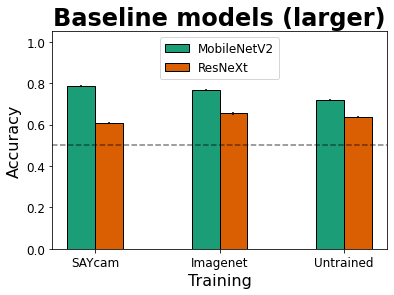

In [48]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None),
    group_bars_by='training', 
    color_bars_by='model', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (6, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

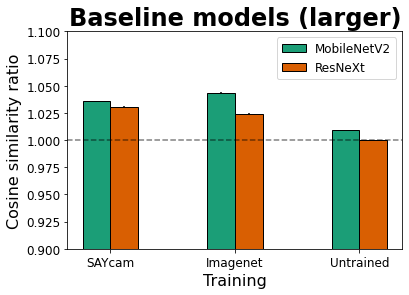

In [8]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None),
    group_bars_by='training', 
    color_bars_by='model', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_ratio',
    compute_std=True,
    # plot style arguments
    figsize = (6, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper right',
    ylim=(0.9, 1.1),
    y_chance=1.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )
    

   

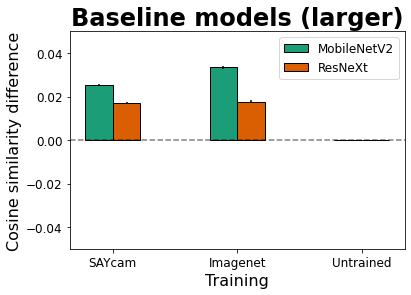

In [9]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None),
    group_bars_by='training', 
    color_bars_by='model', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_diff',
    compute_std=True,
    # plot style arguments
    figsize = (6, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper right',
    ylim=(-0.05, 0.05),
    y_chance=0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )
    

   

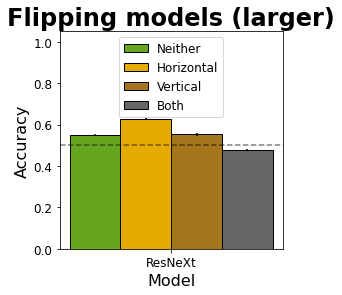

In [10]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='model', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (4, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

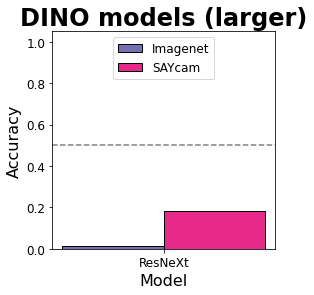

In [11]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='model', 
    color_bars_by='dino', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (4, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'DINO models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

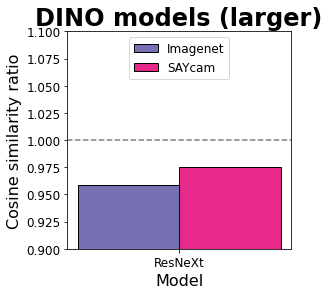

In [12]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='model', 
    color_bars_by='dino', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_ratio',
    compute_std=True,
    # plot style arguments
    figsize = (4, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'DINO models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    ylim=(0.9, 1.1),
    y_chance=1.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

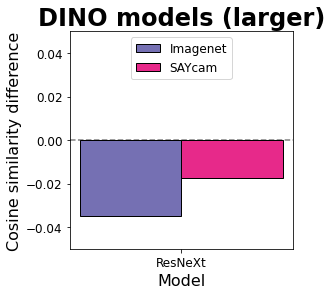

In [13]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='model', 
    color_bars_by='dino', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_diff',
    compute_std=True,
    # plot style arguments
    figsize = (4, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'DINO models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    ylim=(-0.05, 0.05),
    y_chance=0.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

In [14]:
filter_and_group(combined_df, dict(training='DINO'), ['model', 'dino']).correct.mean()

model    dino     
resnext  ImageNet     0.014526
         saycam(S)    0.180176
Name: correct, dtype: float64

In [15]:
combined_df[combined_df.training == 'DINO'][combined_df.dino == 'ImageNet']

/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_51103/3096591689.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combined_df[combined_df.training == 'DINO'][combined_df.dino == 'ImageNet']


,model,training,flip,dino,configuration_index,example_index,bowl_color,target_object,containment_high_containment_cos,containment_behind_cos,containment_support_cos,high_containment_behind_cos,high_containment_support_cos,behind_support_cos,correct,cos_ratio,cos_diff
90112,resnext,DINO,None,ImageNet,0,0,brown,BeachBall,0.804343,0.831115,0.843342,0.957101,0.950721,0.962857,False,0.953756,-0.038999
90113,resnext,DINO,None,ImageNet,0,1,brown,Knight,0.814812,0.831096,0.840265,0.967531,0.927413,0.956427,False,0.969708,-0.025453
90114,resnext,DINO,None,ImageNet,0,2,brown,Lego,0.775471,0.828038,0.819100,0.948759,0.927337,0.950116,False,0.936517,-0.052567
90115,resnext,DINO,None,ImageNet,0,3,brown,Pineapple,0.794823,0.822861,0.838390,0.966071,0.939489,0.962770,False,0.948036,-0.043566
90116,resnext,DINO,None,ImageNet,0,4,brown,Robot,0.773970,0.800056,0.797927,0.947940,0.918619,0.946415,False,0.967394,-0.026087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98299,resnext,DINO,None,ImageNet,1023,8187,green,Pineapple,0.762956,0.786405,0.792696,0.960890,0.917381,0.957085,False,0.962482,-0.029740
98300,resnext,DINO,None,ImageNet,1023,8188,green,Robot,0.770260,0.784666,0.790000,0.957686,0.902389,0.941315,False,0.975013,-0.019740
98301,resnext,DINO,None,ImageNet,1023,8189,green,RubberDuck,0.802627,0.819222,0.830291,0.964096,0.929365,0.966292,False,0.966682,-0.027664
98302,resnext,DINO,None,ImageNet,1023,8190,green,Teddy,0.782382,0.827658,0.818126,0.950773,0.904515,0.949001,False,0.945297,-0.045276


In [16]:
compare_df_group_and_filter(larger_df, smaller_df, 
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='bowl_color', 
    color_bars_by='flip', 
    relevant_fields=('containment_high_containment_cos', 'correct', 'cos_ratio'))

## First dataframe

### Mean:

containment_high_containment_cos   correct  cos_ratio
bowl_color flip                                                       
blue       h                             0.812154  0.613281   1.016083
           hv                            0.725889  0.519531   1.005848
           s                             0.748138  0.560547   1.014467
           v                             0.831304  0.532227   1.005683
brown      h                             0.819041  0.676758   1.019275
           hv                            0.755337  0.421875   0.998294
           s                             0.751768  0.430664   1.000162
           v                             0.833368  0.613281   1.016799
green      h                             0.805337  0.670898   1.021474
           hv                            0.741432  0.463379   1.002512
           s                             0.738151  0.573242   1.014955
           v                             0.832950  0.604004   1.014167
purple     h                             0.790604  0.551758   1.010634
           hv                            0.707886  0.503906   1.001040
           s                             0.727681  0.633301   1.022342
           v                             0.810995  0.460449   0.995067

### Std:

containment_high_containment_cos   correct  cos_ratio
bowl_color flip                                                       
blue       h                             0.057117  0.487117   0.048362
           hv                            0.080414  0.499740   0.059649
           s                             0.068264  0.496442   0.055532
           v                             0.056475  0.499082   0.039489
brown      h                             0.059421  0.467829   0.040441
           hv                            0.073248  0.493979   0.061086
           s                             0.068722  0.495290   0.051621
           v                             0.062365  0.487117   0.045312
green      h                             0.057098  0.470002   0.046849
           hv                            0.070808  0.498779   0.061411
           s                             0.067640  0.494727   0.052386
           v                             0.053730  0.489183   0.042880
purple     h                             0.063568  0.497435   0.049842
           hv                            0.090127  0.500107   0.061590
           s                             0.077698  0.482021   0.054451
           v                             0.068879  0.498555   0.038107

## Second dataframe

### Mean:

containment_high_containment_cos   correct  cos_ratio
bowl_color flip                                                       
blue       h                             0.819901  0.644531   1.020688
           hv                            0.726381  0.535156   1.008524
           s                             0.754077  0.582031   1.017518
           v                             0.838981  0.613281   1.012004
brown      h                             0.814095  0.660156   1.016859
           hv                            0.731886  0.339844   0.989646
           s                             0.721909  0.355469   0.993631
           v                             0.819237  0.531250   1.008276
green      h                             0.809135  0.617188   1.016987
           hv                            0.736895  0.460938   1.005251
           s                             0.728735  0.500000   1.005790
           v                             0.826333  0.589844   1.012781
purple     h                             0.775095  0.449219   0.997747
           hv                            0.699421  0.503906   0.994013
           s                             0.731704  0.535156   1.014197
           v                             0.802832  0.382812   0.989571

### Std:

containment_high_containment_cos   correct  cos_ratio
bowl_color flip                                                       
blue       h                             0.059303  0.479593   0.048670
           hv                            0.079740  0.499740   0.056653
           s                             0.053859  0.494191   0.053066
           v                             0.052206  0.487952   0.037269
brown      h                             0.055918  0.474584   0.040978
           hv                            0.067160  0.474584   0.058739
           s                             0.070296  0.479593   0.058291
           v                             0.071230  0.500000   0.048667
green      h                             0.046472  0.487025   0.045427
           hv                            0.069807  0.499448   0.066761
           s                             0.065411  0.500979   0.051490
           v                             0.052726  0.492825   0.043484
purple     h                             0.065607  0.498389   0.052979
           hv                            0.109219  0.500964   0.066668
           s                             0.086998  0.499740   0.058052
           v                             0.073053  0.487025   0.034165

containment_high_containment_cos   correct  cos_ratio
bowl_color flip                                                       
blue       h                            -0.007747 -0.031250  -0.004606
           hv                           -0.000492 -0.015625  -0.002676
           s                            -0.005939 -0.021484  -0.003051
           v                            -0.007677 -0.081055  -0.006321
brown      h                             0.004946  0.016602   0.002416
           hv                            0.023451  0.082031   0.008648
           s                             0.029859  0.075195   0.006531
           v                             0.014131  0.082031   0.008523
green      h                            -0.003798  0.053711   0.004486
           hv                            0.004537  0.002441  -0.002739
           s                             0.009416  0.073242   0.009165
           v                             0.006617  0.014160   0.001386
purple     h                             0.015508  0.102539   0.012887
           hv                            0.008465  0.000000   0.007027
           s                            -0.004023  0.098145   0.008145
           v                             0.008164  0.077637   0.005495

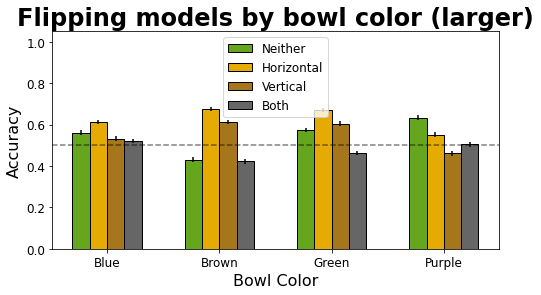

In [17]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='bowl_color', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (8, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by bowl color{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

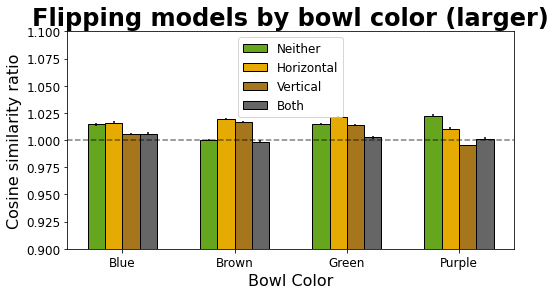

In [18]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='bowl_color', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_ratio',
    compute_std=True,
    # plot style arguments
    figsize = (8, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by bowl color{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper center',
    ylim=(0.9, 1.1),
    y_chance=1.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

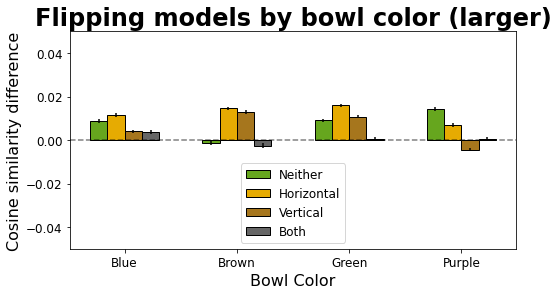

In [19]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='bowl_color', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_diff',
    compute_std=True,
    # plot style arguments
    figsize = (8, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by bowl color{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='lower center',
    ylim=(-0.05, 0.05),
    y_chance=0.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

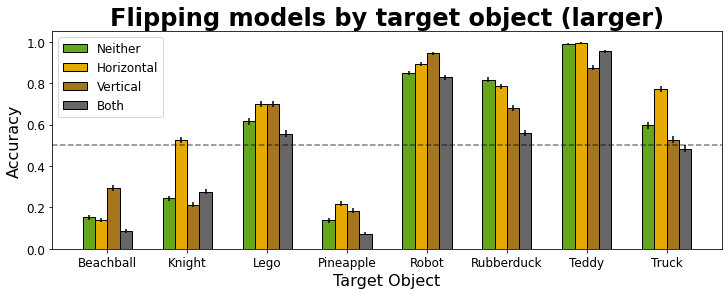

In [20]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper left',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

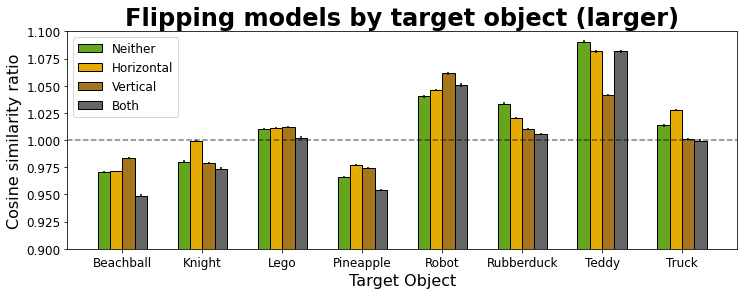

In [21]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_ratio',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper left',
    ylim=(0.9, 1.1),
    y_chance=1.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

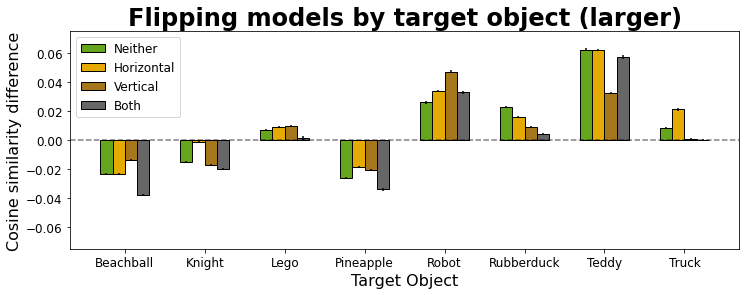

In [22]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    plot_field='cos_diff',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='upper left',
    ylim=(-0.075, 0.075),
    y_chance=0.0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

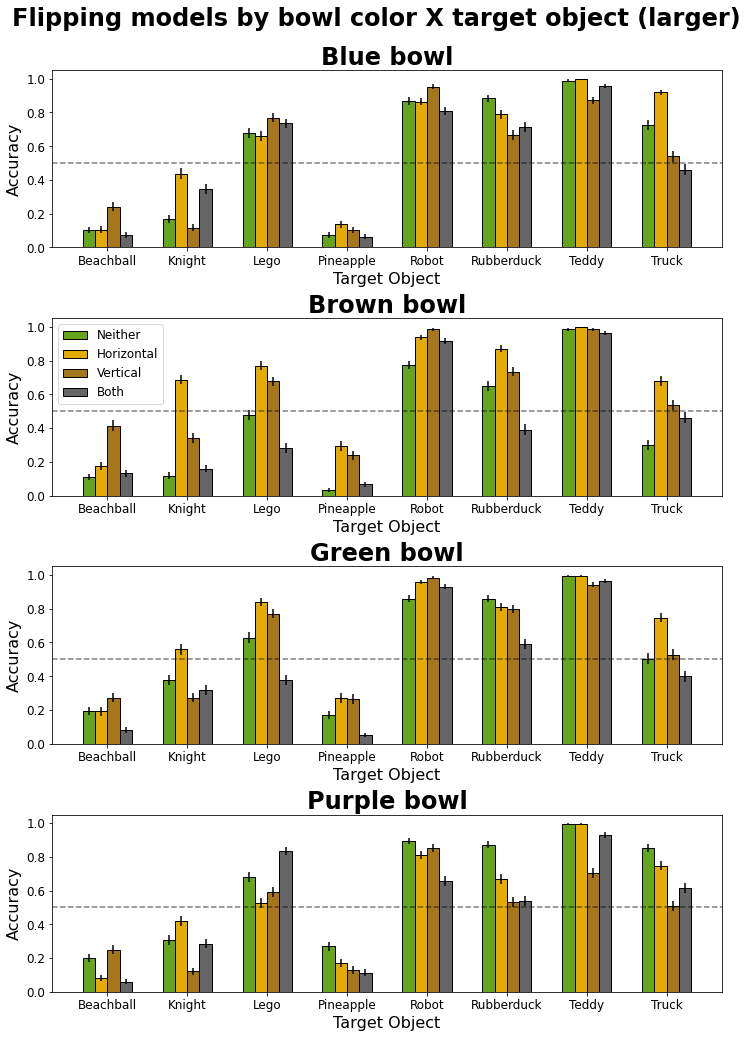

In [23]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    panel_by='bowl_color',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (12, 16),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'Flipping models by bowl color X target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=['Accuracy'] * 4,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

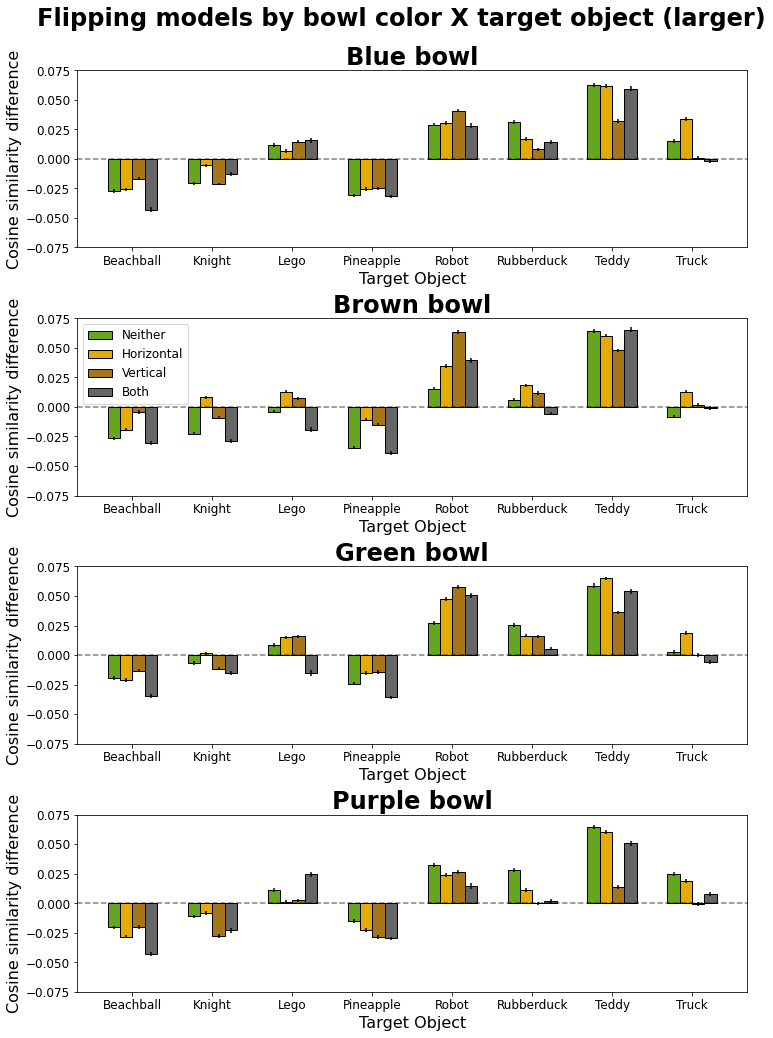

In [24]:
plot_field = 'cos_diff'

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    panel_by='bowl_color',
    # hatch_bars_by='n_target_types',
    plot_field=plot_field,
    compute_std=True,
    # plot style arguments
    figsize = (12, 16),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'Flipping models by bowl color X target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    ylim=(-0.075, 0.075),
    y_chance=0.0,
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=[DEFAULT_YALBELS[plot_field]] * 4,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

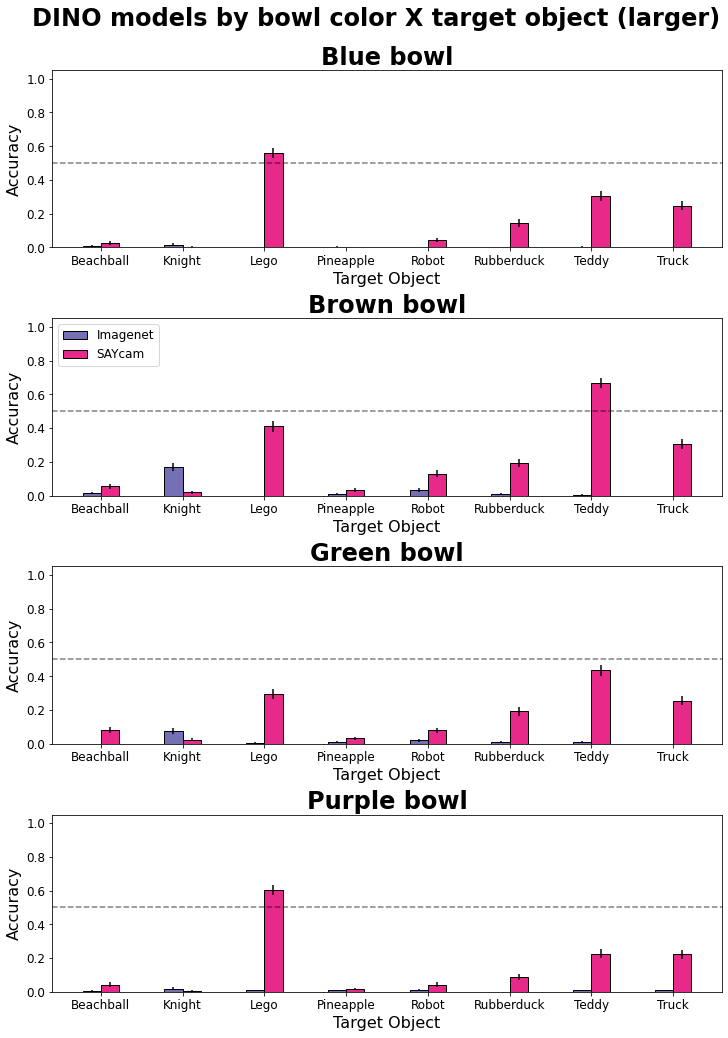

In [25]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='target_object', 
    color_bars_by='dino', 
    panel_by='bowl_color',
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (12, 16),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'DINO models by bowl color X target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=['Accuracy'] * 4,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

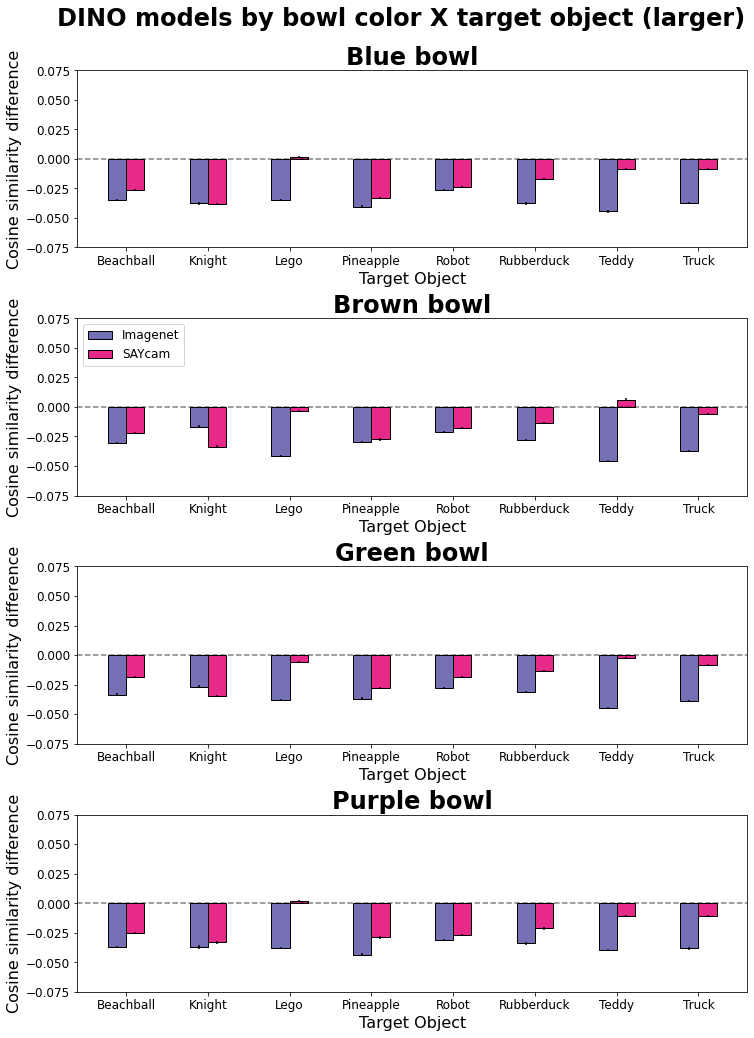

In [26]:
plot_field = 'cos_diff'

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='target_object', 
    color_bars_by='dino', 
    panel_by='bowl_color',
    # hatch_bars_by='n_target_types',
    plot_field=plot_field,
    compute_std=True,
    # plot style arguments
    figsize = (12, 16),
    layout = (4, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'DINO models by bowl color X target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    ylim=(-0.075, 0.075),
    y_chance=0.0,
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=[DEFAULT_YALBELS[plot_field]] * 4,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

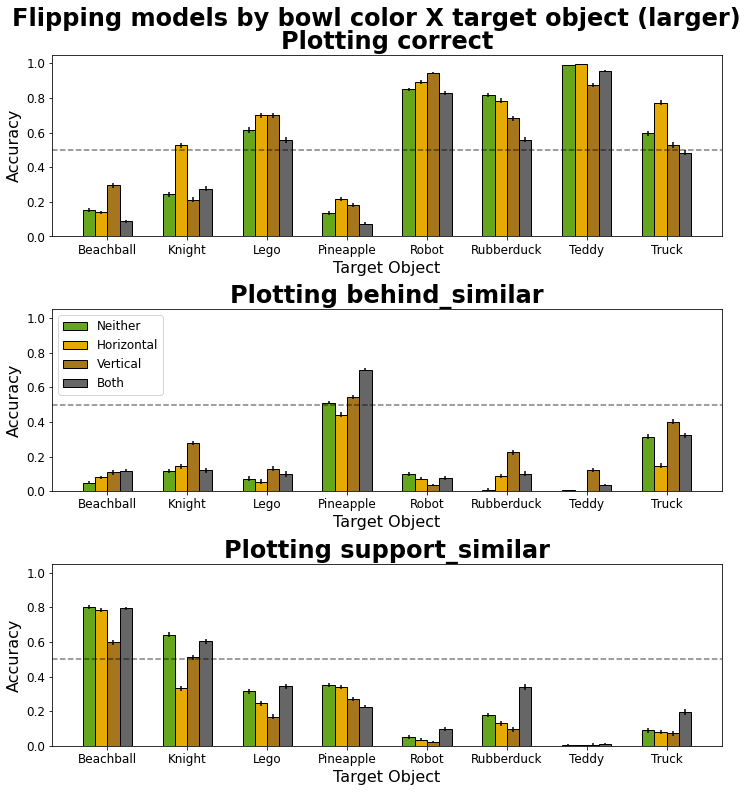

In [52]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    panel_by=['correct', 'behind_similar', 'support_similar'],
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (12, 12),
    layout = (3, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    # panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'Flipping models by bowl color X target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=['Accuracy'] * 3,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

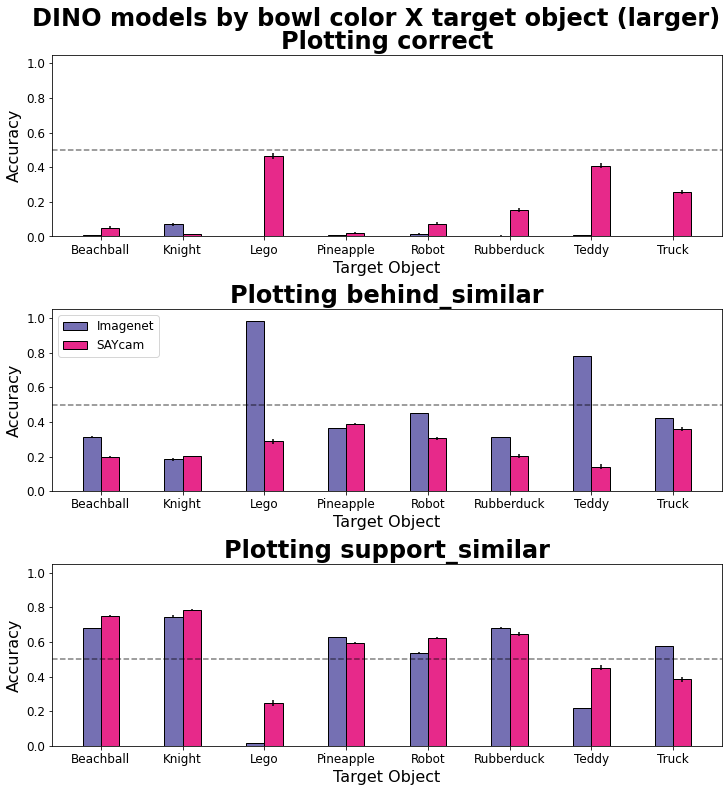

In [54]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='target_object', 
    color_bars_by='dino', 
    panel_by=['correct', 'behind_similar', 'support_similar'],
    # hatch_bars_by='n_target_types',
    plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (12, 12),
    layout = (3, 1),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    # panel_titles=['Blue bowl', 'Brown bowl', 'Green bowl', 'Purple bowl'],
    sup_title=f'DINO models by bowl color X target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    legend_ax_index=1,
    legend_loc='upper left',
    subplot_adjust_params=dict(top=0.925, hspace=0.4),
    ylabel_per_ax=True,
    ylabel=['Accuracy'] * 3,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )